# SUMMARY

The goal of this model is create a tool for predicting the location (borough) of 311 service calls
given variables/features including Status, Agency responding, Complaint Type, and Date.

311 is a non-emergency service call-line that allows residence to place a complaint regarding 
actions or conditions negatively effect the living conditions throughout the city. Complaints are passed on to 
a responding agency for resolution.

This model is a preliminary step in the creation of broader models of NYC open data.

- [Setup](#Setup)
- [Import](#Import)
- [EDA](#EDA)
- [Feature Creation](#FCE)
- [Feature Engineering](#FE2)
- [Random State / Visual EDA](#RSEDA)
- [Accuracy / PreProcessing](#AccPrep)
- [Model Selection](#MS)
- [Conclusion](#Conc)
- [Next Steps](#NS)


<a id='Setup'></a>
## IMPORTS / NOTEBOOK SET-UP

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import sqlite3

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error,accuracy_score,r2_score,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


import pickle

In [3]:
sqlite_db = 'borough.sqlite'
capcon = sqlite3.connect(sqlite_db) 
c = capcon.cursor()

<a id='Import'></a>

## IMPORT DATA FROM CSV FILES

In [4]:
## Because the csv source file has over 1.5 Million rows and +50 columns, a sub-selection was take to only include the 
## values that were non-repetitive and would possibly be included as model features. This saved file space and 
## computational expense.

cp311=pd.read_csv('311_Service_Requests_for_HPD__DOB_and_DEP_for_2016_to_Present.csv',
                low_memory=False,
               usecols=["Created Date", "Latitude", "Longitude","Agency","Borough","Complaint Type","Status","Agency"],
               dtype={"Latitude":np.float32,
                      "Longitude":np.float32,
                      "Agency":'str',
                      "Created Date": 'str',
                      "Complaint Type": 'str',
                      "Status":'str',
                      "Agency":"str",
                      "Borough":'str'},

                )
print(cp311.shape)
cp311.info(memory_usage="deep")

(1570940, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1570940 entries, 0 to 1570939
Data columns (total 7 columns):
Created Date      1570940 non-null object
Agency            1570940 non-null object
Complaint Type    1570940 non-null object
Status            1570915 non-null object
Borough           1570940 non-null object
Latitude          1551934 non-null float32
Longitude         1551934 non-null float32
dtypes: float32(2), object(5)
memory usage: 515.0 MB


<a id='EDA'></a>

## EDA
This section is to standardize feature names and and the data set and remove values that my null values

In [5]:
# Given the large dataset, I chose to drop all rows that have NullValues because they are small percent of the data

cp311 = cp311.dropna(axis = 0).copy()

In [6]:
# Examine the dataframe after the dropping N/A's.
cp311.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1551909 entries, 0 to 1570939
Data columns (total 7 columns):
Created Date      1551909 non-null object
Agency            1551909 non-null object
Complaint Type    1551909 non-null object
Status            1551909 non-null object
Borough           1551909 non-null object
Latitude          1551909 non-null float32
Longitude         1551909 non-null float32
dtypes: float32(2), object(5)
memory usage: 82.9+ MB


In [7]:
# Examine Data details Objects and Numbers
cp311.head(3)

,Created Date,Agency,Complaint Type,Status,Borough,Latitude,Longitude
0,03/06/2016 06:07:00 PM,DEP,Water System,Closed,QUEENS,40.745983,-73.773941
1,01/28/2016 09:10:41 PM,DOB,Building/Use,Closed,BROOKLYN,40.618141,-73.903084
2,03/16/2016 06:16:00 AM,DEP,Sewer,Started,BRONX,40.852383,-73.843513


In [9]:
# Further cleaning on the data to standardize lowercase, and add remove gaps
cp311.columns = [ x.lower().replace(' ','_') for x in cp311.columns]

In [10]:
# Date columns was converted to Datetime in order to use it to convert the index 
cp311["created_date"] = pd.to_datetime(cp311['created_date'],infer_datetime_format=True)

In [11]:
# Exchanging the index to Datetime to allow for future timeseries analysis
cp311['day'] = cp311.created_date.dt.to_period('D')
cp311.set_index('day', inplace=True)
cp311.head(2)

,created_date,agency,complaint_type,status,borough,latitude,longitude
day,,,,,,,
2016-03-06,2016-03-06 18:07:00,DEP,Water System,Closed,QUEENS,40.745983,-73.773941
2016-01-28,2016-01-28 21:10:41,DOB,Building/Use,Closed,BROOKLYN,40.618141,-73.903084


In [62]:
#  Saved file to csv to allow me to open file with initial transformations
#cp311.to_csv('cp311.csv',index=True)

In [368]:
cp311 = pd.read_csv('cp311.csv')

In [12]:
# Further EDA looking at the basic distribution of the target variable

cp311[['status']].groupby([cp311.borough]).count()

,status
borough,
BRONX,396870
BROOKLYN,489306
MANHATTAN,349778
QUEENS,267317
STATEN ISLAND,48638


In [14]:
cp311.head(2)

,created_date,agency,complaint_type,status,borough,latitude,longitude
day,,,,,,,
2016-03-06,2016-03-06 18:07:00,DEP,Water System,Closed,QUEENS,40.745983,-73.773941
2016-01-28,2016-01-28 21:10:41,DOB,Building/Use,Closed,BROOKLYN,40.618141,-73.903084


<a id='FCE'></a>

### FEATURE CREATION / ENGINEERING

Created Dummy variables for the major Feature Categories.
This was done with the thought that regularization and RFE may be used to eliminate less impactful features

In [15]:
dfagency = pd.get_dummies(cp311['agency'])

In [16]:
dfstatus = pd.get_dummies(cp311['status'])

In [17]:
dftype = pd.get_dummies(cp311['complaint_type'])

In [18]:
# Label Encoding to Features to create numeric columns out of original features
# This gives me the flexability to use either the Dummy Columns or the LabelEncoded(single)
# columns in my lists of model features

le = LabelEncoder()
cp311['created_date'] = le.fit_transform(cp311['created_date'])
cp311["complaint_type"] = le.fit_transform(cp311["complaint_type"])
cp311["borough"] = le.fit_transform(cp311["borough"])
cp311["agency"] = le.fit_transform(cp311["agency"])
cp311["status"] = le.fit_transform(cp311["status"])



In [19]:
cp311.head(2)

,created_date,agency,complaint_type,status,borough,latitude,longitude
day,,,,,,,
2016-03-06,151167,0,47,1,3,40.745983,-73.773941
2016-01-28,70046,1,7,1,1,40.618141,-73.903084


<a id='FE2'></a>

## Feature Engineering II
Concatenated the DataFrames to create join the dummy variable columns into the base "cp311" dataframe

In [20]:
cp311 = pd.concat([cp311,dfagency],axis=1,join='inner').copy()

In [21]:
cp311 = pd.concat([cp311,dfstatus],axis=1,join='inner').copy()

In [22]:
cp311 = pd.concat([cp311,dftype],axis=1,join='inner').copy()

In [86]:
# Backup the DataFrame version that includes the Dummy columns

# cp311.to_csv('cp311_Dummies.csv',index = True)

In [125]:
# cp311.drop(['agency','status'],axis = 1, inplace=True)

In [23]:
cp311.head(2)

,created_date,agency,complaint_type,status,borough,latitude,longitude,DEP,DOB,HPD,Assigned,Closed,Open,Started,AGENCY,APPLIANCE,ATF,Air Quality,Asbestos,BEST/Site Safety,Boilers,Building/Use,CST,Construction,Cranes and Derricks,DOOR/WINDOW,ELECTRIC,ELEVATOR,Electrical,Elevator,Emergency Response Team (ERT),FATF,FLOORING/STAIRS,GENERAL,General Construction/Plumbing,HEAT/HOT WATER,Hazardous Materials,Industrial Waste,Interior Demo,Investigations and Discipline (IAD),Lead,Miscellaneous Categories,Noise,OUTSIDE BUILDING,PAINT/PLASTER,PLUMBING,Plant,Plumbing,SAFETY,SRDE,Scaffold Safety,Sewer,Special Enforcement,Special Natural Area District (SNAD),Special Projects Inspection Team (SPIT),Stalled Sites,UNSANITARY CONDITION,VACANT APARTMENT,WATER LEAK,Water Conservation,Water Quality,Water System
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-03-06,151167,0,47,1,3,40.745983,-73.773941,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2016-01-28,70046,1,7,1,1,40.618141,-73.903084,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<a id='RSEDA'></a>

## Random State / Visual EDA

Sampled 20% of the DataFrame(+1M rows) in order to create as sample set for modeling and visualization.  The shape of ~300k rows gave a value that was largely representative of the population and did not result push hardware capabilities.

In [26]:
samp311 = cp311.sample(frac = .2,random_state=757859 )

In [27]:
samp311.agency.value_counts()

2    206086
0     71123
1     33173
Name: agency, dtype: int64

### Visualizations
Look for differentiating features in Complaint types, Response, Agency, and Borough

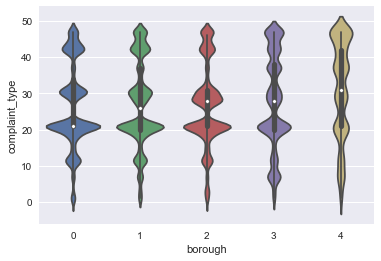

In [282]:
# Look to see if boroughs had different types of complaints, 
sns.violinplot(x="borough", y="complaint_type",data = samp311)

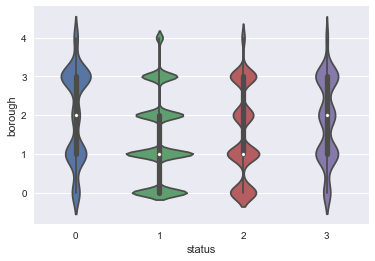

In [446]:
sns.violinplot(x="status", y="borough",data = samp311);

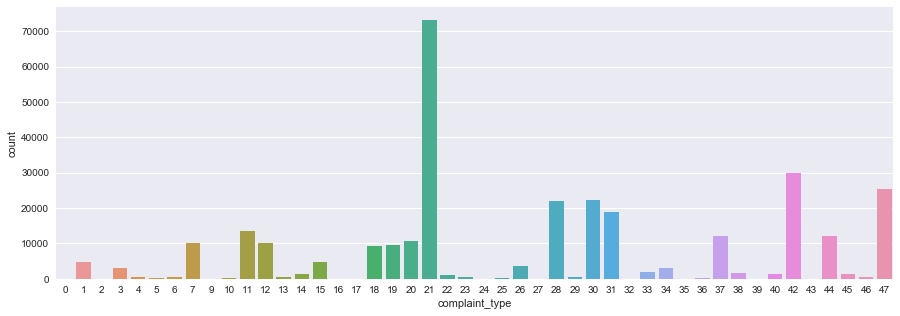

In [309]:
f, ax = plt.subplots(figsize=(15, 5))
sns.countplot(x="complaint_type", data = samp311);

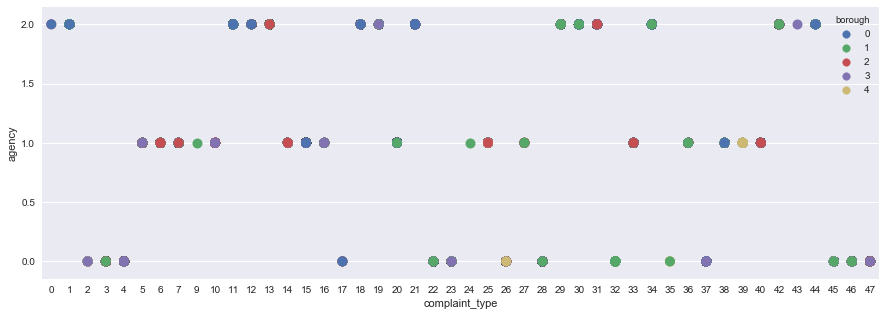

In [310]:
f, ax = plt.subplots(figsize=(15, 5))
sns.stripplot(data=samp311, x="complaint_type",y="agency", hue='borough',size = 10);

<a id='AccPrep'></a>

## Baseline Accuracy
Establish the Baselne Accuracy as a point of comparison for model performance

In [29]:
# Baseline Borough Accuracy  (Most commonly 311 serviced borough / Total 311 service calls ) in millions
.5 / 1.6

0.3125

In [379]:
# Generate a full list of column names, in order to create a list of features to select X and y modeling variables

samp311.columns

Index(['day', 'created_date', 'agency', 'complaint_type', 'status', 'borough',
       'latitude', 'longitude', 'DEP', 'DOB', 'HPD', 'Assigned', 'Closed',
       'Open', 'Started', 'AGENCY', 'APPLIANCE', 'ATF', 'Air Quality',
       'Asbestos', 'BEST/Site Safety', 'Boilers', 'Building/Use', 'CST',
       'Construction', 'Cranes and Derricks', 'DOOR/WINDOW', 'ELECTRIC',
       'ELEVATOR', 'Electrical', 'Elevator', 'Emergency Response Team (ERT)',
       'FATF', 'FLOORING/STAIRS', 'GENERAL', 'General Construction/Plumbing',
       'HEAT/HOT WATER', 'Hazardous Materials', 'Industrial Waste',
       'Interior Demo', 'Investigations and Discipline (IAD)', 'Lead',
       'Miscellaneous Categories', 'Noise', 'OUTSIDE BUILDING',
       'PAINT/PLASTER', 'PLUMBING', 'Plant', 'Plumbing', 'SAFETY', 'SRDE',
       'Scaffold Safety', 'Sewer', 'Special Enforcement',
       'Special Natural Area District (SNAD)',
       'Special Projects Inspection Team (SPIT)', 'Stalled Sites',
       'UNSANITARY COND

In [387]:
# Select/Set features. Removing the base sets listed below, location information (which would be leakage of target)
# and the target variable (borough)

features =['created_date', 'complaint_type',
        'DEP', 'DOB', 'HPD', 'Assigned', 'Closed',
       'Open', 'Started', 'AGENCY', 'APPLIANCE', 'ATF', 'Air Quality',
       'Asbestos', 'BEST/Site Safety', 'Boilers', 'Building/Use', 'CST',
       'Construction', 'Cranes and Derricks', 'DOOR/WINDOW', 'ELECTRIC',
       'ELEVATOR', 'Electrical', 'Elevator', 'Emergency Response Team (ERT)',
       'FATF', 'FLOORING/STAIRS', 'GENERAL', 'General Construction/Plumbing',
       'HEAT/HOT WATER', 'Hazardous Materials', 'Industrial Waste',
       'Interior Demo', 'Investigations and Discipline (IAD)', 'Lead',
       'Miscellaneous Categories', 'Noise', 'OUTSIDE BUILDING',
       'PAINT/PLASTER', 'PLUMBING', 'Plant', 'Plumbing', 'SAFETY', 'SRDE',
       'Scaffold Safety', 'Sewer', 'Special Enforcement',
       'Special Natural Area District (SNAD)',
       'Special Projects Inspection Team (SPIT)', 'Stalled Sites',
       'UNSANITARY CONDITION', 'VACANT APARTMENT', 'WATER LEAK',
       'Water Conservation', 'Water Quality', 'Water System'
          ]

# removed the following items from features list ['status','agency','latitude','longitude','borough']

X = samp311[features].copy()
y = samp311["borough"].copy()

In [417]:
samp311.head(4)

,day,created_date,agency,complaint_type,status,borough,latitude,longitude,DEP,DOB,HPD,Assigned,Closed,Open,Started,AGENCY,APPLIANCE,ATF,Air Quality,Asbestos,BEST/Site Safety,Boilers,Building/Use,CST,Construction,Cranes and Derricks,DOOR/WINDOW,ELECTRIC,ELEVATOR,Electrical,Elevator,Emergency Response Team (ERT),FATF,FLOORING/STAIRS,GENERAL,General Construction/Plumbing,HEAT/HOT WATER,Hazardous Materials,Industrial Waste,Interior Demo,Investigations and Discipline (IAD),Lead,Miscellaneous Categories,Noise,OUTSIDE BUILDING,PAINT/PLASTER,PLUMBING,Plant,Plumbing,SAFETY,SRDE,Scaffold Safety,Sewer,Special Enforcement,Special Natural Area District (SNAD),Special Projects Inspection Team (SPIT),Stalled Sites,UNSANITARY CONDITION,VACANT APARTMENT,WATER LEAK,Water Conservation,Water Quality,Water System
489294,2016-07-25,206,2,18,1,1,40.627048,-73.956657,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
638494,2016-10-09,282,2,42,1,3,40.691269,-73.831116,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
575651,2016-09-03,246,2,30,1,1,40.650700,-73.935104,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1091143,2017-03-22,446,2,31,1,2,40.851414,-73.936172,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [411]:
# Create train and test variable, and cross validation

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = .33, random_state= 7779311)

In [412]:
X_train.shape

(207955, 57)

### FINAL PREPROCESSING
Made preprocessing adjustments to the model to standardize the scale

In [413]:
# Standardize the  features, because there are so many "one hot" columns, i wanted to be sure to dampen the impact
# of the other numeric columns that had larger values(ie. created date, and complaint type )
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

<a id='MS'></a>

## MODEL SELECTION / REFINEMENT

In [414]:
# Chose a Logistic Regression because it was a simple model to evaluate classification problems, and returns
# coeeficient values associated with each feature, which make it the interpretation of impact easily comparable.

lg = LogisticRegression() #C= 500, n_jobs= -1, penalty= 'l2'
# model = lg.fit(X_train,y_train)

In [415]:
# Ran the model with Recursive Feature Elimination in an attempt to find an optimal number of features to use.

rfe = RFE(lg, n_features_to_select=None,step = 1, verbose=2 )
rfmodel = rfe.fit(X_train,y_train)

Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 fe

In [408]:
## RFE to reduce the number of features to 29 (by 1/2)
# rfmodel.score(X_test,y_test)

0.34541673582160953

In [416]:
# Model result with Standardization and RFE(default 1/2 params) for model selection
rfmodel.score(X_test,y_test)

0.35189940152498855

## GRID SEARCH
Created a GridSearch in order to search for best parameter combinations

In [348]:
# Attempt to find best combination of Loss function and Regularization that would maximize the Logistic regression
# accuracy

lg_params= {
    "penalty" :['l1',"l2"],
    'C':[1,10,20,40,100,200,500],
    "n_jobs":[-1]
}

In [349]:
gs = GridSearchCV(lg,param_grid=lg_params,verbose=1,n_jobs = 3)
gsmodel= gs.fit(X_train,y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=3)]: Done  42 out of  42 | elapsed:  1.0min finished


In [350]:
gsmodel.best_params_

{'C': 500, 'n_jobs': -1, 'penalty': 'l2'}

In [391]:
#MODEL SCORE WITH GRID SEARCH BEST PARAMS on 3CV folds/14 params {'C': 500, 'n_jobs': -1, 'penalty': 'l2'}

model.score(X_test,y_test)

0.3527780760932176

<a id='Conc'></a>

## Conclusion
I found that the gridsearching over several parameter and RFE on standardized inputs both resulted in 
Accuracy scores that beat baseline by ~10%.

Although the current  model isn't highly predictive in an absolute since there may be further actions taken in
an attempt to increase accuracy.

<a id='NS'></a>

## Next Steps
- Additional Feature Creation: NLP crossover techniques // occurrence counts
- Make use of Time Series in contextual framework and modelling
- Apply new models; RandomForest, XGBoost, Neural Net
- Incorporate  additional NYC data elements
- Work towards GeoLocation and Real Estate application